# 誤差逆伝播法

## 数値微分の難点

前回までで、ニューラルネットワークの基本的な学習方法である、確率的勾配降下法は実装できた

このとき、勾配の計算は数値微分によって実装していた

数値微分はシンプルに実装できて分かりやすいが、計算に時間がかかるという難点がある

そこで、ここでは、重みパラメータの勾配計算を効率良く行う**誤差逆伝播法**を実装する


## 計算グラフ

誤差逆伝播法を視覚的に理解する方法として**計算グラフ（Computational graph）**というものがある

計算グラフとは計算の過程をグラフによって表したものである

ここで言うグラフとは、データ構造としてのグラフであり、複数のノードとエッジ（ノード間を結ぶ直線）によって表現されるものである

### 計算グラフで計算問題を解く
以下のような簡単な計算問題を、計算グラフを使って解いてみる

**問:** スーパーで1個100円のりんごを2個買ったとき、支払う金額はいくらか？（消費税は10％とする）

計算グラフは以下のように、ノードごとの計算結果が左から右へ伝わるように表現する

![computational_graph01.png](./img/computational_graph01.drawio.png)

上記では、「×2」や「×1.1」を一つの演算として○（ノード）でくくっているが、「×」のような演算子は単一のノードで表現するのが望ましい

この場合、「2」と「1.1」は、それぞれ「りんごの個数」と「消費税」という変数として、ノードの外側に表記する

![computational_graph02.png](./img/computational_graph02.drawio.png)

次に、もう少し複雑な計算を計算グラフで解く

**問:** スーパーでりんご（100円／個）を2個、みかん（150円／個）を3個買ったとき、支払う金額はいくらか？（消費税は10％とする）

この問題を解くための計算グラフは以下のようになる

![computational_graph03.png](./img/computational_graph03.drawio.png)

このように、計算グラフを使って問題を解くには、

1. 計算式に使われる要素を演算子と変数に分ける
2. 演算子と変数をノードとしてエッジでつなぐ
3. 計算グラフ上で計算を左から右へ進める

という流れで作業する

ここで、「計算を左から右へ進める」処理を**順伝播（forward propagation）**と呼び、ニューラルネットワークの**推論処理**に対応する

逆に「計算を右から左へ戻る」処理を**逆伝播（back propagation）**と呼び、ニューラルネットワークの**学習処理**に対応する

この逆伝播は、この先、微分を計算するにあたって重要な働きをする

### 局所的計算と逆伝播による微分
計算グラフを使う利点は大きく以下の2点がある

- 「局所的な計算」を伝播することにより複雑な計算を行うことができる
    - 各ノードは、全体の計算には関与せず「自分に関係する小さな範囲」の計算だけを行う（局所的計算）
    - これにより計算を単純化することができる
    - また、計算途中の結果をすべて、各ノードで保持することも可能
- 計算グラフを逆伝播することで微分値を効率よく計算できる
    - 順伝播が「局所的な計算」であるのと同様に、逆伝播は「局所的な微分」を表す
    - これにより微分計算を単純化し、計算速度を向上させることができる

例えば上記の問題について、りんごの値段が値上がりした場合、最終的な支払金額にどのように影響するか知りたいとする

これは「りんごの値段に対する支払金額の微分」を求めることに相当する（りんごの値段を $x$, 支払金額を $L$ とした場合、$∂L/∂x$ を計算することに相当する）

計算グラフの逆伝播によって、この問題を解くと以下のようになる

![computational_graph04.png](./img/computational_graph04.drawio.png)

上記のように、計算グラフを右から左へ計算することで「局所的な微分」を伝達することができる

この結果から「りんごの値段に関する支払金額の微分」の値は 2.2 であると言える

すなわち、りんごが1円値上がりしたら、最終的な支払金額は2.2円増えることを意味する（正確には、りんごの値段がある微小な値だけ増えたら、最終的な支払金額はその微小な値の2.2倍だけ増加することを意味する）

## 連鎖律

### 計算グラフの逆伝播
計算グラフの逆伝播を一般化すると以下のように表すことができる

![computational_graph05.png](./img/computational_graph05.drawio.png)

ここで、上記計算グラフは $y = f(x)$ という計算を表現している

逆伝播の計算手順は、信号 $E$ に対して、ノードの局所的な微分 $\frac{∂y}{∂x}$ を乗算し、次のノードで伝達する、というものになっている

これは、前述したりんごの支払金額計算で考えると分かりやすい

```
最初のノード: f(x) = 2x (x: 前のノードの出力値＝りんごの値段, 2: りんごの個数)
最後のノード: g(x) = 1.1x (x: 前のノードの出力値, 1.1: 消費税倍率)

最後のノードの逆伝播: 1 * g'(x) = 1 * 1.1 = 1.1
最初のノードの逆伝播: 1.1 * f'(x) = 1.1 * 2 = 2.2
```

この計算により効率よく微分値を求めることができるだが、その理由は**連鎖律の原理**から説明できる

### 連鎖律
以下のような計算グラフを考える

![computational_graph06.png](./img/computational_graph06.drawio.png)

この計算を微分すると、以下のような逆伝播で表現される

![computational_graph07.png](./img/computational_graph07.drawio.png)

ここで、合成関数の定理より $\frac{∂z}{∂z} \frac{∂z}{∂y}$ の $∂z$ は "打ち消し合い"、$\frac{∂z}{∂y}$ となる

同様にして $\frac{∂z}{∂z} \frac{∂z}{∂y} \frac{∂y}{∂x} = \frac{∂z}{∂x}$ となる

このような合成関数の微分の性質を**連鎖律**と呼ぶ

連鎖律により、計算の一部を "打ち消す" ことができるため、効率よく微分計算ができるという仕組みである

## 単純な算術ノードの実装

計算グラフの単純なノードを実装していく

ただし、型名は「ノード」ではなく、ニューラルネットワークの「層（レイヤ）」を意味するものとして `***Layer` という名前で実装することにする

In [1]:
# すべてのレイヤの基底となる抽象型: 抽象レイヤ
abstract type AbstractLayer end

### 加算ノード（加算レイヤ）
まず、加算ノード $z = x + y$ について考える

このノードの逆伝播（偏微分）は以下のようになる

$$ \begin{array}{ll}
    \frac{∂z}{∂x} = 1 \\
    \frac{∂z}{∂y} = 1
\end{array} $$

従って、この計算グラフは以下のようになる

![computational_graph_add.png](./img/computational_graph_add.drawio.png)

上図のように、加算ノードの逆伝播は、上流の値がそのまま分岐して流れていく

これを実装すると以下のようになる

In [2]:
"""
@note:
    forward, backward は引数のレイヤに対して破壊的な変更を加える可能性がある
    => forward!, backward! という関数名で実装しておく
"""
# 加算レイヤ
mutable struct AddLayer <: AbstractLayer end

# 加算レイヤ: 順伝播
## x, y: 上流から流れてきる2値 => 下流に流す値
forward!(layer::AddLayer, x::Float64, y::Float64)::Float64 = x + y

# 加算レイヤ: 逆伝播
## dout: 上流から流れてくる微分値 => 下流に流す2値
backward!(layer::AddLayer, dout::Float64)::Tuple{Float64,Float64} = (dout * 1, dout * 1)

backward! (generic function with 1 method)

### 乗算ノード（乗算レイヤ）
同様に、乗算ノード $z = x \times y$ について考えると、このノードの逆伝播（偏微分）は以下のようになる

$$ \begin{array}{ll}
    \frac{∂z}{∂x} = y \\
    \frac{∂z}{∂y} = x
\end{array} $$
 
従って、この計算グラフは以下のようになる

![computational_graph_mul.png](./img/computational_graph_mul.drawio.png)

すなわち、乗算ノードの逆伝播では、上流から流れてきた微分値に対して、順伝播の "ひっくり返した値" を乗算して流す形になる

これを実装すると以下のようになる

In [3]:
# 乗算レイヤ
mutable struct MulLayer <: AbstractLayer
    x::Float64
    y::Float64
end

MulLayer() = MulLayer(0, 0)

# 乗算レイヤ: 順伝播
## x, y: 上流から流れてきる2値 => 下流に流す値
forward!(layer::MulLayer, x::Float64, y::Float64)::Float64 = begin
    # 順伝播時に値を保持しておく
    layer.x = x
    layer.y = y
    x * y
end

# 乗算レイヤ: 逆伝播
## dout: 上流から流れてくる微分値 => 下流に流す2値
backward!(layer::MulLayer, dout::Float64)::Tuple{Float64,Float64} = (dout * layer.y, dout * layer.x)

backward! (generic function with 2 methods)

これで加算レイヤと乗算レイヤを実装できたため、これらを用いて少し複雑な計算グラフを実装する

前述した「りんご2個とみかん3個の買い物」の計算グラフを以下に示す

![computational_graph_backword.png](./img/computational_graph_backword.drawio.png)

これを実装すると以下のようになる

In [4]:
# 変数
apple = 100.0
apple_num = 2.0
orange = 150.0
orange_num = 3.0
tax = 1.1

# レイヤ（ノード）
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 順伝播
apple_price = forward!(mul_apple_layer, apple, apple_num)
orange_price = forward!(mul_orange_layer, orange, orange_num)
all_price = forward!(add_apple_orange_layer, apple_price, orange_price)
price = forward!(mul_tax_layer, all_price, tax) # => 715

715.0000000000001

In [5]:
# 逆伝播
d_price = 1.0
d_all_price, d_tax = backward!(mul_tax_layer, d_price)
d_apple_price, d_orange_price = backward!(add_apple_orange_layer, d_all_price)
d_orange, d_orange_num = backward!(mul_orange_layer, d_orange_price)
d_apple, d_apple_num = backward!(mul_apple_layer, d_apple_price)

println("$d_apple_num, $d_apple, $d_orange_num, $d_orange, $d_tax")
# => d_apple_num: 110, d_apple: 2.2, d_orange_num: 165, d_orange: 3.3, d_tax: 650

110.00000000000001, 2.2, 165.0, 3.3000000000000003, 650.0


## 活性化関数レイヤの実装

計算グラフの考え方をニューラルネットワークに適用していく

### ReLUレイヤ
ReLU活性化関数は以下の式で表される

$$
    y = \begin{cases}
        x & (x > 0) \\
        0 & (x \leq 0)
    \end{cases}
$$

よって、微分は以下の式で表される

$$
    \frac{∂y}{∂x} = \begin{cases}
        1 & (x > 0) \\
        0 & (x \leq 0)
    \end{cases}
$$

従って、ReLU活性化関数を計算グラフで表すと以下のようになる

![computational_graph_relu.png](./img/computational_graph_relu.drawio.png)

In [6]:
# ReLUレイヤ
mutable struct ReluLayer <: AbstractLayer
    mask::AbstractArray{Bool}
    ReluLayer() = new()
end

# ReLUレイヤ: 順伝播
forward!(layer::ReluLayer, x::AbstractArray{Float64})::AbstractArray{Float64} = begin
    mask = layer.mask = (x .<= 0) # x <= 0 の要素をマスキング
    out = copy(x) # 入力値をそのまま出力値にコピー
    out[mask] .= zero(Float64) # x <= 0 でマスキングした要素それぞれに 0 代入
    out
end

# ReLUレイヤ: 逆伝播
backward!(layer::ReluLayer, dout::AbstractArray{Float64})::AbstractArray{Float64} = begin
    # 基本的に上流から流れてきた微分値をそのまま下流へ
    dout[layer.mask] .= zero(Float64) # x <= 0 でマスキングした要素それぞれに 0 代入
    dout
end

backward! (generic function with 3 methods)

In [7]:
"""
@test: ReLUレイヤ動作確認
"""
# ReLUレイヤ: 順伝播
## [1.0 -0.5; -2.0 3.0] => [1.0 0.0; 0.0 3.0]
layer = ReluLayer()
forward!(layer, [1.0 -0.5; -2.0 3.0])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  3.0

In [8]:
# ReLUレイヤ: マスク状態（x <= 0 のindex）
## => [false true; true false]
layer.mask

2×2 BitMatrix:
 0  1
 1  0

In [9]:
# ReLUレイヤ: 逆伝播
## [1.0 1.0; 1.0 1.0] => [1.0 0.0; 0.0 1.0]
backward!(layer, [1.0 1.0; 1.0 1.0])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

### Sigmoidレイヤ
シグモイド関数は以下の式で表される

$$
    y = \frac{1}{1 + \exp(-x)}
$$

これを計算グラフで表すと以下のようになる

![computational_graph_sigmoid.png](./img/computational_graph_sigmoid.drawio.png)

この計算グラフの逆伝播をステップごとに分解して考えると以下のようになっている

1. 「／」ノードは $y=\frac{1}{x}$ を表し、この微分は解析的に以下のように解くことができる
    $$ \begin{array}{ll}
        \frac{∂y}{∂x} &= -\frac{1}{x^2} \\
                        &= -y^2
    \end{array} $$
2. 「＋」ノードは上流から流れてきた微分値をそのまま下流に流す（加算ノードの項参照）
3. 「exp」ノードは $y=e^x$ を表し、この微分は解析的に以下のように解くことができる
    $$
        \frac{∂y}{∂x} = e^x
    $$
4. 「×」ノードは、順伝播時の2値を "ひっくり返して" 乗算するため、ここでは -1 を乗算している

ここで、$\frac{∂L}{∂y}y^2 e^{-x}$ が順伝播の値 $x$, $y$ のみから計算可能であることに注目すると、上記計算グラフは、以下のように「sigmoid」ノードとしてグループ化することができる

![computational_graph_sigmoid2.png](./img/computational_graph_sigmoid2.drawio.png)

このようにグループ化することで途中の計算を省略することができるため、計算効率を向上させることができる

さらに $\frac{∂y}{∂x}y^2 e^{-x}$ は以下のように展開できるため、さらに整理できる

$$ \begin{array}{ll}
    \frac{∂y}{∂x}y^2 e^{-x} &= \frac{∂y}{∂x}\frac{1}{(1 + e^{-x})^2}e^{-x} & (∵ y = \frac{1}{1 + e^{-x}}) \\
    &= \frac{∂y}{∂x}\frac{1}{1 + e^{-x}}\frac{e^{-x}}{1 + e^{-x}} \\
    &= \frac{∂y}{∂x}y(1-y)
\end{array} $$

従って、最終的に計算グラフは以下のようにまとめることができる

![computational_graph_sigmoid3.png](./img/computational_graph_sigmoid3.drawio.png)

In [10]:
# Sigmoiodレイヤ
mutable struct SigmoidLayer <: AbstractLayer
    out::AbstractArray{Float64} # Sigmoidレイヤが保持しておかなければならないのは順伝播時の出力値 y
end

# Sigmoiodレイヤ: 順伝播
forward!(layer::SigmoidLayer, x::AbstractArray{Float64})::AbstractArray{Float64} =
    layer.out = 1 ./ (1 .+ exp.(-x))

# Sigmoiodレイヤ: 逆伝播
backward!(layer::SigmoidLayer, dout::AbstractArray{Float64})::AbstractArray{Float64} =
    dount .* layer.out .* (1 .- layer.out)

backward! (generic function with 4 methods)

計算グラフを使って途中計算を整理することによって、上記のように逆伝播（微分）を非常に簡単な計算に置き換えられるということは重要である

### Affineレイヤ
ニューラルネットワークの順伝播時で行われる計算は以下のようなものであった

$$
        出力行列 = 入力行列 \cdot 重み行列 + バイアス行列
$$

ここで、行列の内積計算は、幾何学分野で**アフィン変換**と呼ばれる

そのため、ニューラルネットワーク順伝播時の行列計算を行う層を**Affineレイヤ**として実装することにする

まず、計算グラフを考える

ここでは、バッチサイズを $N$, 入力値の数を 2, 重みを 2×3行列（入力数: 2, 出力数: 3）,  バイアスを 1×3行列（出力数: 3）として考えると、計算グラフは以下のようになる

![computational_graph_affine.png](./img/computational_graph_affine.drawio.png)

なお「dot」ノードは、実質的には「×」ノードと同一と考えて良いため、順伝播時の2入力値を "ひっくり返して" 乗算することで逆伝播の流れを作ることができる

ただし、行列の値をひっくり返すということは、転置行列を作ることを意味する

そのため、入力行列 $X$ の側における逆伝播は $\frac{∂L}{∂Y} \cdot W^T$ となり（$W^T$ は $W$ の転置行列）、重み行列 $W$ の側における逆伝播は $X^T \cdot \frac{∂L}{∂Y}$ となっている（$X^T$ は $X$ の転置行列）

In [11]:
# バッチ対応Affineレイヤ
mutable struct AffineLayer <: AbstractLayer
    # AbstractArray型にすることでコンストラクタですべてのメンバの値を指定を不要にする
    W::AbstractArray{Float64,2}
    B::AbstractArray{Float64,2}
    X::AbstractArray{Float64,2}
    dW::AbstractArray{Float64,2}
    dB::AbstractArray{Float64,2}
    
    # コンストラクタで重みとバイアスだけ指定できるように定義
    function AffineLayer(W::AbstractArray{Float64,2}, B::AbstractArray{Float64,2})
        layer = new()
        layer.W = W
        layer.B = B
        layer
    end
end

# Affineレイヤ: 順伝播
forward!(layer::AffineLayer, x::Array{Float64,2})::Array{Float64,2} = begin
    layer.X = x
    x * layer.W .+ layer.B
end

# Affineレイヤ: 逆伝播
backward!(layer::AffineLayer, dout::Array{Float64,2})::Array{Float64,2} = begin
    dX = dout * layer.W'
    layer.dW = layer.X' * dout
    layer.dB = sum(dout, dims=1) # バイアスの逆伝播値: ∂L/∂Y の最初の軸に対する和
    dX
end

backward! (generic function with 5 methods)

In [12]:
"""
@test: Affineレイヤ動作確認
"""
# Affineレイヤ
## 重み行列: 1×3（入力数: 1, 出力数: 3）
## バイアス行列: 1×3（出力数: 3）
layer = AffineLayer([5.0 5.0 5.0], [1.0 2.0 3.0])

# 順伝播
## 入力行列: 2×1（バッチサイズ: 2, 特徴量の数: 1）
x = reshape([0.0; 2.0], 2, 1)
forward!(layer, x) # => 2×3 [1 2 3; 11 12 13]

2×3 Matrix{Float64}:
  1.0   2.0   3.0
 11.0  12.0  13.0

In [13]:
# 逆伝播
## 入力微分値: 2×3行列（バッチサイズ: 2, Affineレイヤの順伝播出力数: 3）
dY = [1.0 2.0 3.0; 4.0 5.0 6.0]
backward!(layer, dY) # => 2×1 行列 X に戻る [30; 75]

2×1 Matrix{Float64}:
 30.0
 75.0

In [14]:
# 逆伝播後の微分バイアス
layer.dB # => 1×3 [5 7 9]

1×3 Matrix{Float64}:
 5.0  7.0  9.0

### Softmaxレイヤ
Softmax活性化関数は以下の数式で表される

$$
    y_i = \frac{e^{x_i}}{\sum_{i=1}^N e^{x_i}}
$$

計算グラフで表すと以下のようになる

![computational_graph_softmax.png](./img/computational_graph_softmax.drawio.png)

続いて、①〜⑥の経路について逆伝播を考える

1. $\frac{∂L}{∂y_i}$
2. 「×」ノードのため、順伝播時の相方を乗算する
    $$
        \frac{∂L}{∂y_i} \cdot e^{x_i}
    $$
3. 「／」ノードのため、順伝播時の出力値を2乗し符号反転したものを乗算する
    - 更にそれらを合計する
    $$ \begin{array}{ll}
        -\sum_{i=1}{N}\frac{∂L}{∂y_i} \cdot e^{x_i} \cdot \frac{1}{S^2} \\
        = -\sum_{i=1}^{N}\frac{∂L}{∂y_i} \cdot \frac{y_i}{S} &(∵ y_i = \frac{e^{x_i}}{S})
    \end{array} $$
4. 「×」ノードのため、順伝播時の相方を乗算する
    $$
        \frac{∂L}{∂y_i} \cdot \frac{1}{S}
    $$
5. 「＋」ノードのため、上流値をそのまま流す
    $$
        -\sum_{i=1}^{N}\frac{∂L}{∂y_i} \cdot \frac{y_i}{S}
    $$
6. 「exp」ノードのため、順伝播時の出力値を乗算する
    - 今回の場合、上流値が④と⑤の2つあるため、これらの合計値に順伝播時の出力値を乗算することになる
    $$ \begin{array}{ll}
        (\frac{∂L}{∂y_i} \cdot \frac{1}{S} - \sum_{j=1}^{N}\frac{∂L}{∂y_j} \cdot \frac{y_j}{S}) \cdot e^{x_i} \\
        = \frac{1}{S}(\frac{∂L}{∂y_i} - \sum_{j=1}^{N}\frac{∂L}{∂y_j}y_j) \cdot e^{x_i} \\
        = y_i(\frac{∂L}{∂y_i} - \sum_{j=1}^{N}\frac{∂L}{∂y_j}y_j) &(∵ y_i = \frac{e^{x_i}}{S})
    \end{array} $$

### Softmaxレイヤ＋交差エントロピー誤差レイヤ
上記のようにSoftmaxレイヤの逆伝播計算は少々複雑になってしまっている

しかし、交差エントロピー誤差レイヤを組み合わせることで非常に簡単な式に展開することができる

ここで改めて、交差エントロピー誤差の式を掲載する

$$ \begin{array}{ll}
    E = - \sum_{k} t_k \times \ln{y_k}
    \\
    k: データの次元数 \\
    y_k: ニューラルネットワークの出力（予測値） \\
    t_k: 教師データ（正解値）
    \ln: 底がe(自然定数)の対数
\end{array} $$

この計算グラフは以下のようになる

![computational_graph_entropy.png](./img/computational_graph_entropy.drawio.png)

このとき、交差エントロピー誤差の入力値 $y_i$ が、Softmaxレイヤの出力値 $y_i = \frac{e^{x_i}}{S}$ であるとする（Softmaxレイヤと交差エントロピー誤差レイヤが連続的に接続されているとする）

この場合、計算としては、Softmaxレイヤの逆伝播の出力値 $y_i(\frac{∂L}{∂y_i} - \sum_{j=1}^{N}\frac{∂L}{∂y_j}y_j)$ に対して、以下のような置換処理を施せば良い

$$
    \frac{∂L}{∂y_i} → -(\frac{t_i}{y_i})\frac{∂E}{∂y_i}
$$

したがって、Softmaxレイヤの逆伝播の出力値は以下のように展開できる

$$ \begin{array}{ll}
    y_i(\frac{∂L}{∂y_i} - \sum_{j=1}^{N}\frac{∂L}{∂y_j}y_j) \\
    = y_i(-(\frac{t_i}{y_i})\frac{∂E}{∂y_i} - \sum_{j=1}^{N}-(y_j\frac{t_j}{y_j})\frac{∂E}{∂y_j}) \\
    = -t_i\frac{∂E}{∂y_i} + y_i\sum_{j=1}^{N}t_j\frac{∂E}{∂y_j} \\
    = -t_i\frac{∂E}{∂y_i} + y_i\frac{∂E}{∂y_i} &(∵ t: one-hot表現のため正解データのみ 1 で、それ以外のデータが 0 となる) \\
    = (y_i - t_i)\cdot \frac{∂E}{∂y_i}
\end{array} $$

以上より、Softmax＋交差エントロピー誤差レイヤは以下のように表現できる

![computational_graph_softmax-entropy.png](./img/computational_graph_softmax-entropy.drawio.png)

In [15]:
# softmax, cross_entropy_error 関数等読み込み
include("./lib/Functions.jl")

# Softmax with Cross entropy error Layer
mutable struct SoftmaxWithLossLayer <: AbstractLayer
    loss::Float64 # 最終結果（誤差）
    y::AbstractArray{Float64} # SoftmaxレイヤからCrossEntropyErrorレイヤへのデータ
    t::AbstractArray{Float64} # 教師データ
    SoftmaxWithLossLayer() = new()
end

# 順伝播関数
## y: 予測結果行列, t: 教師データ行列 => loss: 誤差
forward!(layer::SoftmaxWithLossLayer, y::Array{Float64,2}, t::Array{Float64,2})::Float64 = begin
    layer.t = t
    y = layer.y = softmax(y)
    layer.loss = cross_entropy_error(y, t)
end

# 逆伝播関数
## 教師データは 1×N 行列である想定であるため、バッチサイズで除算する必要あり
backward!(layer::SoftmaxWithLossLayer, dout::Float64=1.0)::Array{Float64,2} = (layer.y .- layer.t) .* dout ./ size(layer.y, 1)

backward! (generic function with 7 methods)

## 誤差逆伝播法によるニューラルネットワーク

これまでに実装したレイヤを組み合わせることで、誤差逆伝播法に対応したニューラルネットワークを実装する

ここでは、以下のような二層ニューラルネットワークを構築する

- 入力層:
    - 手書き数字の画像データ（サイズ: 28x28）
    - ニューロン数: 28 * 28 = 784
    - 各ニューロンの入力値は 0.0〜1.0 の実数型である必要がある
- 中間層（隠れ層）1: `Affine`レイヤ => `ReLU`活性化レイヤ
    - ニューロン数: 100
- 出力層: `Affine`レイヤ => `SoftmaxWithLoss`誤差伝播レイヤ
    - ニューロン数: 10（0〜9の数字クラスに分類するため）

In [16]:
# 二層ニューラルネットワーク
mutable struct TwoLayerNet
    affine_layer1::AffineLayer
    relu_layer::ReluLayer
    affine_layer2::AffineLayer
    softmax_layer::SoftmaxWithLossLayer
end

TwoLayerNet(input_size::Int, hidden_size::Int, output_size::Int, weight_init_std::Float64=0.01) = begin
    W1 = weight_init_std .* rand(Float64, input_size, hidden_size)
    b1 = zeros(Float64, 1, hidden_size)
    W2 = weight_init_std .* rand(Float64, hidden_size, output_size)
    b2 = zeros(Float64, 1, output_size)
    a1lyr = AffineLayer(W1, b1)
    relu1lyr = ReluLayer()
    a2lyr = AffineLayer(W2, b2)
    softmaxlyr = SoftmaxWithLossLayer()
    # TwoLayerNet(W1, b1, W2, b2, a1lyr, relu1lyr, a2lyr, softmaxlyr)
    TwoLayerNet(a1lyr, relu1lyr, a2lyr, softmaxlyr)
end

# 二層ニューラルネットワーク: 順伝播（分類まで）
predict!(net::TwoLayerNet, x::Array{Float64,2})::Array{Float64,2} = begin
    a1 = forward!(net.affine_layer1, x)
    z1 = forward!(net.relu_layer, a1)
    a2 = forward!(net.affine_layer2, z1)
    # 本来なら最後にsoftmax関数を噛ませるが
    ## あえて確率を求めなくても a2 の大小で分類できるため計算を省略する
    # softmax(a2)
    a2
end

# 二層ニューラルネットワーク: 順伝播（誤差の算出まで）
loss!(net::TwoLayerNet, x::Array{Float64,2}, t::Array{Float64,2})::Float64 = forward!(net.softmax_layer, predict!(net, x), t)

loss! (generic function with 1 method)

In [17]:
# 誤差逆伝播: 更新用構造体
struct TwoLayerNetGrads
    W1::Array{Float64,2}
    b1::Array{Float64,2}
    W2::Array{Float64,2}
    b2::Array{Float64,2}
end

# 逆伝播による微分計算
gradient!(net::TwoLayerNet, x::Array{Float64,2}, t::Array{Float64,2}) = begin
    # forward
    loss!(net, x, t)
    # backward
    dout = one(Float64)
    dz2 = backward!(net.softmax_layer, dout)
    da2 = backward!(net.affine_layer2, dz2)
    dz1 = backward!(net.relu_layer, da2)
    da1 = backward!(net.affine_layer1, dz1)
    TwoLayerNetGrads(net.affine_layer1.dW, net.affine_layer1.dB, net.affine_layer2.dW, net.affine_layer2.dB)
end

# パラメータ更新
apply_gradient!(net::TwoLayerNet, grads::TwoLayerNetGrads, learning_rate::Float64) = begin
    net.affine_layer1.W -= learning_rate .* grads.W1
    net.affine_layer1.B -= learning_rate .* grads.b1
    net.affine_layer2.W -= learning_rate .* grads.W2
    net.affine_layer2.B -= learning_rate .* grads.b2
end

apply_gradient! (generic function with 1 method)

In [18]:
"""
@test: 誤差逆伝播法の勾配確認
"""
# MLDatasetsパッケージのMNISTSデータセットを使う
using MLDatasets

# 訓練用画像データと教師データをロード
## train_x: 特徴量＝<画像データ｜28x28 グレースケール画像 60,000枚>{28x28x60000 Array{UInt8, 3}}
## train_y: 目的変数＝<数値クラス｜[0..9]の数値 60,000個>{60000 Array{Int, 1}}
train_x, train_y = MNIST.traindata()

# 学習データをニューラルネットワーク用に前処理
train_x = Array{Float64,3}(reshape(train_x, 1, 28*28, :)) # 1 x 784 x 60000 Array{Float64,3}
train_x = permutedims(train_x, [3, 2, 1]) # 60000 x 784 x 1 Array{Float64,3}
train_x = Array{Float64,2}(reshape(train_x, :, 784)) # 60000 x 784 Array{Float64,2}

# 教師データをone-hot-vector形式に変換
train_y = Array{Float64,2}(hcat([[i-1 == y ? 1.0 : 0.0 for i in 1:10] for y in train_y]...)') # 60000 x 10 Array{Float64,2}

# 損失関数の履歴
train_loss_list = []

# ハイパーパラメータ
batch_size = 3 # ミニバッチサイズ
learning_rate = 0.1 # 学習率

# 二層ニューラルネットワーク
## 入力サイズ: 28×28 = 784, 隠れ層: 100ニューロン, 出力層: 10ニューロン
net = TwoLayerNet(784, 100, 10)

# 推論実行
y = predict!(net, train_x[1:batch_size, :])

3×10 Matrix{Float64}:
 0.270196  0.245477  0.266659  0.291558  …  0.283902  0.277243  0.276954
 0.305784  0.278299  0.303876  0.328864     0.319693  0.313166  0.313107
 0.192043  0.174384  0.190427  0.207234     0.201949  0.196731  0.198356

In [19]:
# 推論＋誤差計算
loss!(net, train_x[1:batch_size, :], train_y[1:batch_size, :])

2.311979006309565

In [20]:
# 逆伝播による微分
grads = @time gradient!(net, train_x[1:batch_size, :], train_y[1:batch_size, :])

## => 前回、数値微分で行った場合は同一の計算に約66秒かかっていたが
### 今回の逆伝播による微分は 0.001秒未満の時間で計算できている

  0.135448 seconds (288.37 k allocations: 16.814 MiB, 98.25% compilation time)


TwoLayerNetGrads([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [9.072536789250265e-5 0.00183524029814145 … -0.0008425956204536603 0.0005832872852367418], [-0.1682124841628821 0.05143142220798033 … 0.053047912655159166 0.05306043356553113; -0.151134730685512 0.050010581494249945 … 0.05155993838340416 0.05157559559993636; … ; -0.15180332563122564 0.04996628207221803 … 0.05152276341508578 0.0515367547864858; -0.16177919526025542 0.0526411125895983 … 0.05427730558342254 0.05429293664984494], [-0.23340970638270153 0.09762435961341137 … 0.10056247519341974 0.10060522226874019])

In [21]:
"""
誤差逆伝播法で実装されたニューラルネットワークによるMNIST学習
"""
# 履歴
train_loss_list = [] # 損失関数の履歴
train_acc_list = [] # 訓練用データでの精度の履歴
test_acc_list = [] # テスト用データでの精度の履歴

# ハイパーパラメータ
iters_num = 10000 # パラメータ更新回数
train_size = size(train_x, 1) # 学習データ枚数: 60,000
batch_size = 100 # ミニバッチサイズ
learning_rate = 0.1 # 学習率

# 2層ニューラルネットワーク
## 入力サイズ: 28×28 = 784, 隠れ層: 50ニューロン, 出力層: 10ニューロン
net = TwoLayerNet(784, 50, 10)

# 学習関数
train!(net::TwoLayerNet) = begin
    # ミニバッチ取得: 対象データ群から batch_size 個のデータを抜き出し
    batch_mask = rand(1:train_size, batch_size)
    batch_x = train_x[batch_mask, :]
    batch_y = train_y[batch_mask, :]
    
    # 誤差逆伝播法によって勾配を求める
    grads = gradient!(net, batch_x, batch_y)
    
    # 更新
    apply_gradient!(net, grads, learning_rate)
    
    # 学習経過の記録
    loss_value = loss!(net, batch_x, batch_y)
    push!(train_loss_list, loss_value)
end

# 学習実行
## iters_num = 1回で 約0.1秒程度かかる(Intel(C) Core i7-7700 3.6 GHz の場合)
@time train!(net)
train_loss_list

  0.272510 seconds (166.37 k allocations: 11.721 MiB, 98.54% compilation time)


1-element Vector{Any}:
 2.2922260007869055

In [22]:
# 予測精度算出関数
accuracy(net::TwoLayerNet, x::Array{Float64,2}, t::Array{Float64,2})::Float64 = begin
    pred = predict!(net, x)
    ind = getindex.(argmax(pred; dims=2), [2]) # 予測値: 行ごとの最大値のindex（1..10）を取得
    t_ind = getindex.(argmax(t; dims=2), [2]) # 教師データ: 行ごとの最大値のindex（1..10）を取得
    length(ind[ind .== t_ind]) / size(t, 1)
end

# 指定回数学習を繰り返す関数
train!(
    net::TwoLayerNet, iters_num::Int, iters_per_epoch::Int,
    train_x::Array{Float64,2}, train_y::Array{Float64,2},
    test_x::Array{Float64,2}, test_y::Array{Float64,2}
) = begin
    for i = 1:iters_num
        train!(net)
        if i % iter_per_epoch == 1
            train_acc = accuracy(net, train_x, train_y)
            test_acc = accuracy(net, test_x, test_y)
            push!(train_acc_list, train_acc)
            push!(test_acc_list, test_acc)
            println("$(i): train_acc=$(train_acc) / test_acc=$(test_acc)")
        end
    end
end

# テスト用画像データと教師データをロード
test_x, test_y = MNIST.testdata()

# データをニューラルネットワーク用に前処理
test_x = Array{Float64,3}(reshape(test_x, 1, 28*28, :))
test_x = permutedims(test_x, [3, 2, 1])
test_x = Array{Float64,2}(reshape(test_x, :, 28*28))
test_y = Array{Float64,2}(hcat([[i-1 == y ? 1.0 : 0.0 for i in 1:10] for y in test_y]...)')

10000×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0

In [23]:
# 1エポックあたりの繰り返し回数
iter_per_epoch = Int(max(train_size / batch_size, 1))

# 初期化
train_loss_list = [] # 損失関数の履歴
train_acc_list = [] # 訓練用データでの精度の履歴
test_acc_list = [] # テスト用データでの精度の履歴
net = TwoLayerNet(784, 50, 10)

# 学習実行
## 10,000回の学習 => 30〜40秒程度で完了（Intel(C) Core i7-7700 3.6 GHz の場合）
@time train!(net, iters_num, iter_per_epoch, train_x, train_y, test_x, test_y)

1: train_acc=0.09751666666666667 / test_acc=0.0974
601: train_acc=0.8969333333333334 / test_acc=0.9006
1201: train_acc=0.9203 / test_acc=0.9228
1801: train_acc=0.9326333333333333 / test_acc=0.9342
2401: train_acc=0.9335166666666667 / test_acc=0.9339
3001: train_acc=0.9468333333333333 / test_acc=0.9448
3601: train_acc=0.9531666666666667 / test_acc=0.9505
4201: train_acc=0.9559666666666666 / test_acc=0.9512
4801: train_acc=0.9614666666666667 / test_acc=0.9571
5401: train_acc=0.96375 / test_acc=0.9573
6001: train_acc=0.96615 / test_acc=0.9614
6601: train_acc=0.96805 / test_acc=0.9609
7201: train_acc=0.97115 / test_acc=0.9634
7801: train_acc=0.9730666666666666 / test_acc=0.9658
8401: train_acc=0.9741 / test_acc=0.9673
9001: train_acc=0.9748166666666667 / test_acc=0.9672
9601: train_acc=0.977 / test_acc=0.968
 27.759777 seconds (12.97 M allocations: 27.987 GiB, 1.95% gc time)


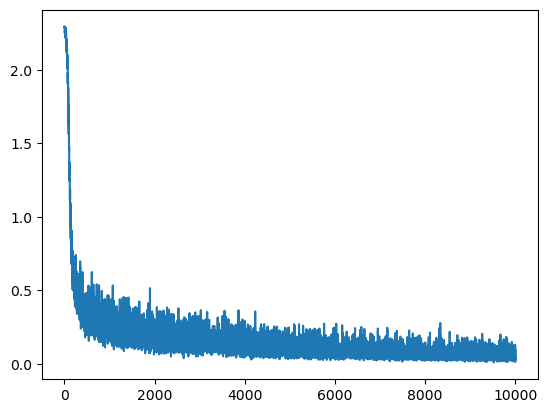

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f328021a2b0>

In [24]:
"""
@plot: 学習履歴をグラフ化
"""
# PyPlot利用
using PyPlot

# 損失関数の推移
plot(train_loss_list)

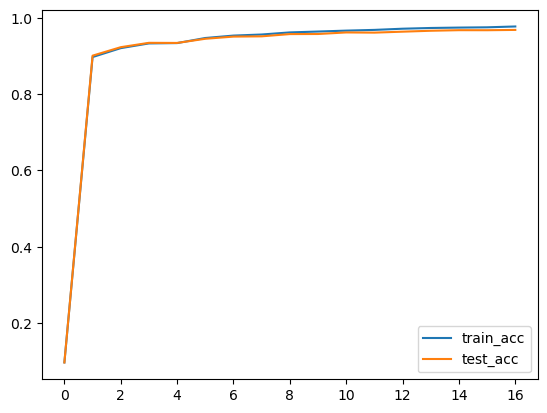

PyObject <matplotlib.legend.Legend object at 0x7f32800ad1c0>

In [25]:
# 予測精度の推移
plot(train_acc_list; label="train_acc")
plot(test_acc_list; label="test_acc")
legend()

今回、訓練用データとテスト用データ両方を使った予測精度を追っているが、これは **過学習（オーバーフィッティング）** を防ぐのが目的である

ディープラーニングにおいては、学習回数を増やせば増やすほど、ニューラルネットワークのパラメータは最適化されていくが、それが訓練用データに対して最適化されすぎると未知のデータに対しての予測精度が低下してしまうことがある

このような現象を過学習と呼ぶ

これを防ぐための手段の一つとして、学習回数を適切な回数に調整するという方法がある

すなわち、訓練用データに対する予測精度が上がり続けているのに、テスト用データ（未知のデータ）に対する予測精度が下がり始めた辺りの学習回数を限度とする方法である

今回の場合で言うと、おそらく学習回数 4,000回目くらいから過学習が起こり始めているので、このくらいの回数で学習を切り上げるのが良さそうである

また、グラフより、このニューラルネットワークモデルの最終的な予測精度は 95.5％程度 と言える

## Summary

ここまでの内容をまとめる

ミニバッチ学習や確率的勾配降下法など、学習効率を向上させるための各種テクニックが出てきたが、概念的に特に重要なのは以下の4つである

- パーセプトロン
    - パーセプトロンはディープラーニング（ディープニューラルネットワーク）の起源とされるアルゴリズム
    - 0 or 1 の二値からなる入力信号を受け取り、特定の計算処理を行うことで 0 or 1 の二値を出力する
    - 単層パーセプトロンでは線形分離可能な問題しか解けないが、層を重ねることで線形分離不可能な問題も解ける
- ニューラルネットワーク
    - パーセプトロンの構造を拡張した計算アルゴリズム
    - 計算処理を活性化関数という関数に置き換えることでより汎用的な計算が可能となっている
    - パーセプトロン同様、層を重ねることで「深い」計算が可能となり、それがディープラーニング・アルゴリズムの骨子である
- 勾配降下法
    - ディープラーニングにおける学習の本質はパラメータの最適化であり、その手法として広く用いられているのが勾配降下法である
    - 勾配とは偏微分計算で求められる微小変化量のことであり、関数グラフの傾きのことである
    - 勾配はその点における最適点の方向を向くため、勾配の示す方向にパラメータを調整していくことで最適化ができるという仕組み
- 誤差逆伝播法
    - 勾配計算において、数値微分を利用すると計算処理に莫大な時間がかかってしまうため、その対策のために用いられる手法
    - 計算グラフの逆伝播が微分計算になるという性質を利用して微分を行う
    - 連鎖律の原理により重複する計算等を省略できるため、高速に微分計算を行うことができる